<a href="https://colab.research.google.com/github/vphcap-res/DOA_deep_learning/blob/main/DOA_NN_20250213_resampling_finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install requirements**

In [40]:
#import os
#print(os.listdir())  # List all files in the current directory

In [41]:
# Install the dependencies from requirements.txt
#!pip install -r /content/requirements.txt

# Verify that packages are installed
#!pip freeze

# **Data prep**

In [58]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler  # Import ROS for resampling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import os

In [43]:
# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [44]:
# Ensure full determinism in TensorFlow operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

print("✅ Random seed set. Training will be reproducible.")

# Ensure deterministic TensorFlow behavior
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

✅ Random seed set. Training will be reproducible.


In [45]:
# Uploaded file
df = pd.read_excel('DOA-data_65-66_for_NN.xlsx')

In [46]:
# Select relevant columns
columns_to_select = ['head', 'age', 'bw', 'lairagetemp', 'season', 'timetransport', 'durationtransport', 'lairagetime', 'classdoa']
df2 = df[columns_to_select]

In [47]:
# Encode the target variable (classdoa)
label_encoder = LabelEncoder()
df2.loc[:, 'classdoa'] = label_encoder.fit_transform(df2['classdoa'])
target = df2['classdoa'].astype(int).values  # Ensure y is an integer 1D array

# **Train-test split**
**Resampling & 10-fold CV**

In [48]:
# Perform stratified splitting before preprocessing
predictors = df2.drop('classdoa', axis=1)

In [49]:
# Identify actual categorical columns
existing_categorical_cols = [col for col in ['season', 'timetransport'] if col in predictors.columns]
print("✅ Categorical columns found:", existing_categorical_cols)

# One-hot encode categorical variables BEFORE resampling
if existing_categorical_cols:
    predictors = pd.get_dummies(predictors, columns=existing_categorical_cols, drop_first=True)

# Split Data into Train (80%) and Test (20%) BEFORE CV
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.2, random_state=SEED, stratify=target
)

# Ensure y_train is an integer 1D array before applying ROS
y_train = y_train.astype(int).ravel()

# Apply Random Over-Sampling (ROS) to balance the training dataset
ros = RandomOverSampler(random_state=SEED)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Convert target to categorical format
y_train_resampled = to_categorical(y_train_resampled)
y_test = to_categorical(y_test.astype(int))

# Ensure feature consistency between training and test sets
X_test = X_test.reindex(columns=X_train_resampled.columns, fill_value=0)

# Check dataset shape
print("✅ Shape of X_train_resampled:", X_train_resampled.shape)
print("✅ Shape of y_train_resampled:", y_train_resampled.shape)
print("✅ Shape of X_test:", X_test.shape)
print("✅ Shape of y_test:", y_test.shape)

✅ Categorical columns found: ['season', 'timetransport']
✅ Shape of X_train_resampled: (10306, 10)
✅ Shape of y_train_resampled: (10306, 2)
✅ Shape of X_test: (1644, 10)
✅ Shape of y_test: (1644, 2)


## **Experiments: Selection of baseline model**

In [54]:
# Define multiple model architectures
model_configs = [
    {'name': 'Model 1', 'layers': [100]},
    {'name': 'Model 2', 'layers': [100, 100]},
    {'name': 'Model 3', 'layers': [200]},
    {'name': 'Model 4', 'layers': [200, 200]}
]

# Perform 10-Fold Cross-Validation on Training Set
k = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Store cross-validation results
cv_results = {}

def build_model(layers):
    model = Sequential()
    model.add(Input(shape=(X_train_resampled.shape[1],)))
    for neurons in layers:
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate through different model architectures
for model_config in model_configs:
    print(f"\n🔹 Running Cross-Validation for {model_config['name']}...")
    accuracy_scores = []
    loss_scores = []
    early_stopping_monitor = EarlyStopping(patience=3, restore_best_weights=True)

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_resampled, np.argmax(y_train_resampled, axis=1))):
        X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
        y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]

        model = build_model(model_config["layers"])
        model.fit(X_train_fold, y_train_fold, epochs=30, verbose=0, callbacks=[early_stopping_monitor], validation_data=(X_val_fold, y_val_fold))

        loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracy_scores.append(accuracy)
        loss_scores.append(loss)
        print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}, Loss = {loss:.4f}")

    cv_results[model_config["name"]] = {
        "mean_accuracy": np.mean(accuracy_scores),
        "std_accuracy": np.std(accuracy_scores),
        "mean_loss": np.mean(loss_scores),
        "std_loss": np.std(loss_scores)
    }

# Print cross-validation results
print("\n📊 Cross-Validation Results:")
for model, result in cv_results.items():
    print(f"{model}: Mean Accuracy = {result['mean_accuracy']:.4f} ± {result['std_accuracy']:.4f}")


🔹 Running Cross-Validation for Model 1...
Fold 1: Accuracy = 0.6605, Loss = 0.6164
Fold 2: Accuracy = 0.6809, Loss = 0.6173
Fold 3: Accuracy = 0.6625, Loss = 0.6181
Fold 4: Accuracy = 0.6363, Loss = 0.6384
Fold 5: Accuracy = 0.6751, Loss = 0.6178
Fold 6: Accuracy = 0.6615, Loss = 0.6304
Fold 7: Accuracy = 0.6854, Loss = 0.5989
Fold 8: Accuracy = 0.6903, Loss = 0.5893
Fold 9: Accuracy = 0.6757, Loss = 0.6162
Fold 10: Accuracy = 0.6806, Loss = 0.6177

🔹 Running Cross-Validation for Model 2...
Fold 1: Accuracy = 0.6625, Loss = 0.6166
Fold 2: Accuracy = 0.6120, Loss = 0.6584
Fold 3: Accuracy = 0.6469, Loss = 0.6316
Fold 4: Accuracy = 0.6654, Loss = 0.6094
Fold 5: Accuracy = 0.6469, Loss = 0.6365
Fold 6: Accuracy = 0.6751, Loss = 0.6121
Fold 7: Accuracy = 0.7058, Loss = 0.6149
Fold 8: Accuracy = 0.6893, Loss = 0.6060
Fold 9: Accuracy = 0.6670, Loss = 0.6134
Fold 10: Accuracy = 0.6408, Loss = 0.6486

🔹 Running Cross-Validation for Model 3...
Fold 1: Accuracy = 0.6615, Loss = 0.6214
Fold 2: 

In [55]:
# Select the best model
best_model = max(cv_results, key=lambda model: (cv_results[model]["mean_accuracy"], -cv_results[model]["mean_loss"]))
print(f"\n🏆 Best Model: {best_model} with Mean Accuracy = {cv_results[best_model]['mean_accuracy']:.4f}")

# Print cross-validation results
print("\n📊 Cross-Validation Results:")
for model, result in cv_results.items():
    print(f"{model}: Mean Accuracy = {result['mean_accuracy']:.4f} ± {result['std_accuracy']:.4f}, Mean Loss = {result['mean_loss']:.4f}")


🏆 Best Model: Model 1 with Mean Accuracy = 0.6709

📊 Cross-Validation Results:
Model 1: Mean Accuracy = 0.6709 ± 0.0151, Mean Loss = 0.6160
Model 2: Mean Accuracy = 0.6612 ± 0.0250, Mean Loss = 0.6247
Model 3: Mean Accuracy = 0.6678 ± 0.0203, Mean Loss = 0.6172
Model 4: Mean Accuracy = 0.6675 ± 0.0257, Mean Loss = 0.6133


In [56]:
# ✅ Step 4: Select Best Model and Train on Full Training Set
best_model_config = max(cv_results, key=lambda x: cv_results[x]["mean_accuracy"])
print(f"\n🎯 Best Model Selected: {best_model_config}")

# Retrieve best model architecture
best_layers = next(m["layers"] for m in model_configs if m["name"] == best_model_config)

# Define final model with best architecture
final_model = Sequential()
final_model.add(Input(shape=(X_train_resampled.shape[1],)))
for neurons in best_layers:
    final_model.add(Dense(neurons, activation='relu'))
    final_model.add(BatchNormalization())
    final_model.add(Dropout(0.3))
final_model.add(Dense(2, activation='softmax'))  # Output layer

# Compile final model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train final model on full training set
final_model.fit(X_train_resampled, y_train_resampled, epochs=30, verbose=1)

# ✅ Step 5: Evaluate on Unseen Test Set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"\n📌 Final Model Test Accuracy: {test_accuracy:.4f}")
print(f"📌 Final Model Test Loss: {test_loss:.4f}")


🎯 Best Model Selected: Model 1
Epoch 1/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5953 - loss: 0.7310
Epoch 2/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6428 - loss: 0.6580
Epoch 3/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6597 - loss: 0.6323
Epoch 4/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6682 - loss: 0.6221
Epoch 5/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6649 - loss: 0.6190
Epoch 6/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6670 - loss: 0.6170
Epoch 7/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6699 - loss: 0.6148
Epoch 8/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6667 - loss: 0.6143
Epoch 9/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6723 - loss: 0.6116
Epoch 10/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6738 - loss: 0.6083
Epoch 11/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6772 - loss: 0.6104
Epoch 12/30
323/323 

# **Model 1 Test Performance**

In [59]:
# ✅ Step 6: Model Performance Evaluation
y_pred_prob = final_model.predict(X_test)  # Get probability outputs
y_pred = np.argmax(y_pred_prob, axis=1)    # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)         # Convert one-hot labels to class labels

# Compute Performance Metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# Print Performance Metrics
print("\n📊 **Final Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📊 **Final Model Performance on Test Set** 📊
✅ Accuracy: 0.7482
✅ Precision: 0.7867
✅ Recall: 0.7482
✅ F1-score: 0.7619
✅ AUC Score: 0.7509

🔍 **Detailed Classification Report:**
              precision    recall  f1-score   support

           0       0.44      0.62      0.52       356
           1       0.88      0.78      0.83      1288

    accuracy                           0.75      1644
   macro avg       0.66      0.70      0.67      1644
weighted avg       0.79      0.75      0.76      1644



# **Model Optimization**

In [60]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ✅ Define Hyperparameters for Fine-Tuning
learning_rate = 0.001  # Optimized learning rate
dropout_rate = 0.3  # Dropout for regularization
batch_size = 32  # Batch size for stable updates
epochs = 50  # Increase training time for better convergence

# ✅ Build the Fine-Tuned Model
fine_tuned_model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),  # Input layer

    Dense(128, activation='relu'),  # More neurons
    BatchNormalization(),  # Normalize activations
    Dropout(dropout_rate),  # Regularization

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(2, activation='softmax')  # Output layer (binary classification)
])

# ✅ Compile the Model with Optimized Learning Rate
optimizer = Adam(learning_rate=learning_rate)
fine_tuned_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Add Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ✅ Train the Fine-Tuned Model
history = fine_tuned_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = fine_tuned_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = fine_tuned_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Fine-Tuned Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5501 - loss: 0.8510 - val_accuracy: 0.3802 - val_loss: 0.7658 - learning_rate: 0.0010
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.6823 - val_accuracy: 0.5219 - val_loss: 0.7118 - learning_rate: 0.0010
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6436 - loss: 0.6434 - val_accuracy: 0.6344 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6594 - loss: 0.6223 - val_accuracy: 0.2184 - val_loss: 1.8239 - learning_rate: 0.0010
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6726 - loss: 0.6152 - val_accuracy: 0.8041 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6686 - loss: 0.6138 - val_accuracy: 0.8060 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6745 - loss: 0.6068 - 

## **Hyperparameter Optimization with Manual Hyperparameter Search**

In [61]:
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define a function to train and evaluate different hyperparameters
def train_model(learning_rate, dropout_rate, neurons):
    model = Sequential([
        Input(shape=(X_train_resampled.shape[1],)),
        Dense(neurons, activation=LeakyReLU(alpha=0.1)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(neurons//2, activation=LeakyReLU(alpha=0.1)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(2, activation='softmax')  # Output layer
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(
        X_train_resampled, y_train_resampled,
        epochs=50, batch_size=32, verbose=1,
        validation_data=(X_test, y_test)
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    return test_accuracy

# Define hyperparameter values to test
learning_rates = [0.001, 0.0005, 0.0001]
dropout_rates = [0.2, 0.3, 0.4]
neurons_options = [64, 128, 256]

best_accuracy = 0
best_params = {}

# Iterate over different hyperparameter combinations
for lr in learning_rates:
    for dr in dropout_rates:
        for neurons in neurons_options:
            print(f"\n🔹 Testing Model with LR={lr}, Dropout={dr}, Neurons={neurons}")
            accuracy = train_model(learning_rate=lr, dropout_rate=dr, neurons=neurons)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"learning_rate": lr, "dropout_rate": dr, "neurons": neurons}

# Print the best hyperparameters
print("\n🎯 Best Hyperparameters Found:")
print(best_params)


🔹 Testing Model with LR=0.001, Dropout=0.2, Neurons=64
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5706 - loss: 0.7609 - val_accuracy: 0.3644 - val_loss: 0.8222
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6029 - loss: 0.6760 - val_accuracy: 0.5864 - val_loss: 0.6830
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6461 - loss: 0.6384 - val_accuracy: 0.7926 - val_loss: 0.5287
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6606 - loss: 0.6246 - val_accuracy: 0.5468 - val_loss: 0.7534
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6695 - loss: 0.6134 - val_accuracy: 0.3887 - val_loss: 0.9059
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6674 - loss: 0.6118 - val_accuracy: 0.7908 - val_loss: 0.5320
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6771 - loss: 0.6081 - val_accuracy: 0.4757 - val_loss: 0.8025
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6840 - loss: 0.6036 - val_accuracy: 0.8090 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5814 - loss: 0.7625 - val_accuracy: 0.7950 - val_loss: 0.4688
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6368 - loss: 0.6521 - val_accuracy: 0.2585 - val_loss: 1.1694
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6628 - loss: 0.6298 - val_accuracy: 0.4842 - val_loss: 0.7968
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6645 - loss: 0.6141 - val_accuracy: 0.4702 - val_loss: 0.7987
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6770 - loss: 0.6068 - val_accuracy: 0.7068 - val_loss: 0.5957
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6807 - loss: 0.6072 - val_accuracy: 0.8041 - val_loss: 0.4592
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6750 - loss: 0.6058 - val_accuracy: 0.6344 - val_loss: 0.6517
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6793 - loss: 0.6024 - val_accuracy: 0.7974 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5788 - loss: 0.8195 - val_accuracy: 0.7810 - val_loss: 0.5111
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6448 - loss: 0.6605 - val_accuracy: 0.7999 - val_loss: 0.4977
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6625 - loss: 0.6261 - val_accuracy: 0.7993 - val_loss: 0.4922
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6668 - loss: 0.6182 - val_accuracy: 0.7981 - val_loss: 0.4490
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6758 - loss: 0.6099 - val_accuracy: 0.2232 - val_loss: 1.5443
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6668 - loss: 0.6099 - val_accuracy: 0.4811 - val_loss: 0.7808
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6769 - loss: 0.6067 - val_accuracy: 0.8102 - val_loss: 0.4822
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6821 - loss: 0.6047 - val_accuracy: 0.7871 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5609 - loss: 0.8088 - val_accuracy: 0.2810 - val_loss: 1.0131
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6020 - loss: 0.6747 - val_accuracy: 0.4519 - val_loss: 0.7283
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6315 - loss: 0.6468 - val_accuracy: 0.5237 - val_loss: 0.6952
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6592 - loss: 0.6268 - val_accuracy: 0.3248 - val_loss: 0.8880
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6639 - loss: 0.6175 - val_accuracy: 0.8029 - val_loss: 0.4901
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6754 - loss: 0.6123 - val_accuracy: 0.7245 - val_loss: 0.5933
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6769 - loss: 0.6124 - val_accuracy: 0.7828 - val_loss: 0.5306
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6763 - loss: 0.6112 - val_accuracy: 0.4878 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5737 - loss: 0.8380 - val_accuracy: 0.4872 - val_loss: 0.7112
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6165 - loss: 0.6728 - val_accuracy: 0.2372 - val_loss: 1.0086
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6463 - loss: 0.6380 - val_accuracy: 0.3826 - val_loss: 0.8813
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6669 - loss: 0.6238 - val_accuracy: 0.8023 - val_loss: 0.4977
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6742 - loss: 0.6131 - val_accuracy: 0.8047 - val_loss: 0.4973
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6780 - loss: 0.6093 - val_accuracy: 0.6168 - val_loss: 0.6654
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6747 - loss: 0.6106 - val_accuracy: 0.7962 - val_loss: 0.5136
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6775 - loss: 0.6111 - val_accuracy: 0.8041 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5770 - loss: 0.8429 - val_accuracy: 0.5140 - val_loss: 0.7344
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6276 - loss: 0.6650 - val_accuracy: 0.6247 - val_loss: 0.6572
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6620 - loss: 0.6300 - val_accuracy: 0.7981 - val_loss: 0.5189
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6640 - loss: 0.6182 - val_accuracy: 0.8041 - val_loss: 0.4825
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6745 - loss: 0.6083 - val_accuracy: 0.7585 - val_loss: 0.5559
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6701 - loss: 0.6136 - val_accuracy: 0.7920 - val_loss: 0.5187
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6753 - loss: 0.6098 - val_accuracy: 0.4203 - val_loss: 0.8706
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6785 - loss: 0.6057 - val_accuracy: 0.7232 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5538 - loss: 0.9116 - val_accuracy: 0.4611 - val_loss: 0.6819
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5908 - loss: 0.6974 - val_accuracy: 0.6752 - val_loss: 0.6459
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6220 - loss: 0.6526 - val_accuracy: 0.7470 - val_loss: 0.5786
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6549 - loss: 0.6348 - val_accuracy: 0.6965 - val_loss: 0.6215
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6418 - loss: 0.6371 - val_accuracy: 0.3193 - val_loss: 0.8610
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6559 - loss: 0.6259 - val_accuracy: 0.7092 - val_loss: 0.6034
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6597 - loss: 0.6243 - val_accuracy: 0.7804 - val_loss: 0.5362
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6669 - loss: 0.6202 - val_accuracy: 0.7354 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5680 - loss: 0.9371 - val_accuracy: 0.4647 - val_loss: 0.6937
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5857 - loss: 0.7053 - val_accuracy: 0.6813 - val_loss: 0.6396
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6220 - loss: 0.6527 - val_accuracy: 0.3911 - val_loss: 0.8256
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6518 - loss: 0.6288 - val_accuracy: 0.4373 - val_loss: 0.7971
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6678 - loss: 0.6201 - val_accuracy: 0.8023 - val_loss: 0.4796
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6764 - loss: 0.6141 - val_accuracy: 0.7153 - val_loss: 0.5994
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6742 - loss: 0.6120 - val_accuracy: 0.4635 - val_loss: 0.7885
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6788 - loss: 0.6101 - val_accuracy: 0.4489 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5714 - loss: 0.9027 - val_accuracy: 0.5955 - val_loss: 0.6979
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6255 - loss: 0.6891 - val_accuracy: 0.5596 - val_loss: 0.7217
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6383 - loss: 0.6519 - val_accuracy: 0.4264 - val_loss: 0.7880
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6656 - loss: 0.6226 - val_accuracy: 0.7591 - val_loss: 0.5690
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6665 - loss: 0.6182 - val_accuracy: 0.7567 - val_loss: 0.5600
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6706 - loss: 0.6131 - val_accuracy: 0.4161 - val_loss: 0.8151
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6755 - loss: 0.6099 - val_accuracy: 0.7299 - val_loss: 0.5804
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6792 - loss: 0.6085 - val_accuracy: 0.7348 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5495 - loss: 0.8484 - val_accuracy: 0.7646 - val_loss: 0.5863
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5856 - loss: 0.7101 - val_accuracy: 0.6983 - val_loss: 0.6405
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6235 - loss: 0.6664 - val_accuracy: 0.2865 - val_loss: 1.0285
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6494 - loss: 0.6342 - val_accuracy: 0.7877 - val_loss: 0.5325
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6558 - loss: 0.6309 - val_accuracy: 0.5024 - val_loss: 0.7759
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6625 - loss: 0.6215 - val_accuracy: 0.5839 - val_loss: 0.7079
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6699 - loss: 0.6135 - val_accuracy: 0.8035 - val_loss: 0.5145
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6640 - loss: 0.6137 - val_accuracy: 0.6642 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5673 - loss: 0.7575 - val_accuracy: 0.4331 - val_loss: 0.7211
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6256 - loss: 0.6643 - val_accuracy: 0.3844 - val_loss: 0.8485
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6443 - loss: 0.6417 - val_accuracy: 0.2658 - val_loss: 1.0888
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6539 - loss: 0.6284 - val_accuracy: 0.7336 - val_loss: 0.5670
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6573 - loss: 0.6220 - val_accuracy: 0.7287 - val_loss: 0.5680
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6767 - loss: 0.6147 - val_accuracy: 0.4453 - val_loss: 0.8332
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6742 - loss: 0.6109 - val_accuracy: 0.4647 - val_loss: 0.8291
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6722 - loss: 0.6049 - val_accuracy: 0.7476 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5875 - loss: 0.8147 - val_accuracy: 0.7743 - val_loss: 0.5468
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6234 - loss: 0.6795 - val_accuracy: 0.5821 - val_loss: 0.7126
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6414 - loss: 0.6581 - val_accuracy: 0.7050 - val_loss: 0.5911
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6542 - loss: 0.6378 - val_accuracy: 0.5018 - val_loss: 0.7797
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6565 - loss: 0.6350 - val_accuracy: 0.8066 - val_loss: 0.4604
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6723 - loss: 0.6213 - val_accuracy: 0.7354 - val_loss: 0.5743
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6779 - loss: 0.6059 - val_accuracy: 0.7993 - val_loss: 0.4486
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6800 - loss: 0.6068 - val_accuracy: 0.7944 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5316 - loss: 0.9239 - val_accuracy: 0.7622 - val_loss: 0.5455
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5783 - loss: 0.7227 - val_accuracy: 0.6727 - val_loss: 0.6306
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5980 - loss: 0.6802 - val_accuracy: 0.7561 - val_loss: 0.5813
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6480 - loss: 0.6374 - val_accuracy: 0.7956 - val_loss: 0.5378
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6586 - loss: 0.6298 - val_accuracy: 0.7847 - val_loss: 0.5513
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6589 - loss: 0.6262 - val_accuracy: 0.6308 - val_loss: 0.6635
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6748 - loss: 0.6134 - val_accuracy: 0.8023 - val_loss: 0.5193
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6698 - loss: 0.6142 - val_accuracy: 0.8060 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5665 - loss: 0.8364 - val_accuracy: 0.7731 - val_loss: 0.5730
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6110 - loss: 0.7022 - val_accuracy: 0.7877 - val_loss: 0.5344
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6376 - loss: 0.6636 - val_accuracy: 0.4015 - val_loss: 0.8603
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6433 - loss: 0.6510 - val_accuracy: 0.5395 - val_loss: 0.7330
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6560 - loss: 0.6301 - val_accuracy: 0.6916 - val_loss: 0.6064
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6595 - loss: 0.6214 - val_accuracy: 0.3498 - val_loss: 0.9799
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6652 - loss: 0.6249 - val_accuracy: 0.5894 - val_loss: 0.6954
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6676 - loss: 0.6158 - val_accuracy: 0.3869 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5694 - loss: 0.8757 - val_accuracy: 0.3692 - val_loss: 0.8158
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6090 - loss: 0.7246 - val_accuracy: 0.7092 - val_loss: 0.5985
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6356 - loss: 0.6649 - val_accuracy: 0.5493 - val_loss: 0.7137
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6479 - loss: 0.6481 - val_accuracy: 0.8011 - val_loss: 0.4584
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6623 - loss: 0.6250 - val_accuracy: 0.5906 - val_loss: 0.6947
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6694 - loss: 0.6174 - val_accuracy: 0.7457 - val_loss: 0.5659
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6739 - loss: 0.6130 - val_accuracy: 0.8127 - val_loss: 0.4916
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6777 - loss: 0.6125 - val_accuracy: 0.6338 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5437 - loss: 0.9954 - val_accuracy: 0.7050 - val_loss: 0.5988
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5663 - loss: 0.7930 - val_accuracy: 0.7281 - val_loss: 0.6403
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5774 - loss: 0.7247 - val_accuracy: 0.6655 - val_loss: 0.6766
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5923 - loss: 0.6987 - val_accuracy: 0.7074 - val_loss: 0.6492
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5988 - loss: 0.6721 - val_accuracy: 0.5955 - val_loss: 0.6974
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6131 - loss: 0.6560 - val_accuracy: 0.6807 - val_loss: 0.6539
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6212 - loss: 0.6510 - val_accuracy: 0.5602 - val_loss: 0.7071
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6418 - loss: 0.6374 - val_accuracy: 0.5912 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5649 - loss: 0.8904 - val_accuracy: 0.5882 - val_loss: 0.6453
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5855 - loss: 0.7272 - val_accuracy: 0.7263 - val_loss: 0.6258
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5950 - loss: 0.6938 - val_accuracy: 0.7080 - val_loss: 0.6255
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6119 - loss: 0.6644 - val_accuracy: 0.2165 - val_loss: 1.6507
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6498 - loss: 0.6341 - val_accuracy: 0.5870 - val_loss: 0.6889
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6633 - loss: 0.6266 - val_accuracy: 0.2324 - val_loss: 1.2741
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6658 - loss: 0.6180 - val_accuracy: 0.8054 - val_loss: 0.4977
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6701 - loss: 0.6163 - val_accuracy: 0.7999 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5566 - loss: 0.9703 - val_accuracy: 0.4386 - val_loss: 0.7421
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6035 - loss: 0.7472 - val_accuracy: 0.2974 - val_loss: 1.0826
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6193 - loss: 0.6892 - val_accuracy: 0.3747 - val_loss: 0.8625
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6251 - loss: 0.6563 - val_accuracy: 0.7901 - val_loss: 0.5547
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6580 - loss: 0.6332 - val_accuracy: 0.2737 - val_loss: 1.1453
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6626 - loss: 0.6290 - val_accuracy: 0.8035 - val_loss: 0.5041
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6643 - loss: 0.6210 - val_accuracy: 0.8084 - val_loss: 0.4807
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6747 - loss: 0.6146 - val_accuracy: 0.3911 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5229 - loss: 0.9488 - val_accuracy: 0.7032 - val_loss: 0.6117
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5839 - loss: 0.7693 - val_accuracy: 0.6807 - val_loss: 0.6530
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5702 - loss: 0.7661 - val_accuracy: 0.7159 - val_loss: 0.6292
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5754 - loss: 0.7365 - val_accuracy: 0.7038 - val_loss: 0.6275
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5898 - loss: 0.7120 - val_accuracy: 0.6740 - val_loss: 0.6445
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5885 - loss: 0.7135 - val_accuracy: 0.6314 - val_loss: 0.6681
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5850 - loss: 0.7139 - val_accuracy: 0.7080 - val_loss: 0.6236
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5995 - loss: 0.6957 - val_accuracy: 0.7178 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5064 - loss: 0.8831 - val_accuracy: 0.7336 - val_loss: 0.5952
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5667 - loss: 0.7653 - val_accuracy: 0.6764 - val_loss: 0.6383
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5698 - loss: 0.7448 - val_accuracy: 0.6746 - val_loss: 0.6396
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5791 - loss: 0.7415 - val_accuracy: 0.6314 - val_loss: 0.6590
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5872 - loss: 0.7232 - val_accuracy: 0.5505 - val_loss: 0.6885
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5909 - loss: 0.6999 - val_accuracy: 0.5845 - val_loss: 0.6750
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6270 - loss: 0.6695 - val_accuracy: 0.7652 - val_loss: 0.5567
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6354 - loss: 0.6662 - val_accuracy: 0.7360 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5439 - loss: 0.9246 - val_accuracy: 0.5383 - val_loss: 0.7035
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5877 - loss: 0.7655 - val_accuracy: 0.5201 - val_loss: 0.7334
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5979 - loss: 0.7310 - val_accuracy: 0.7038 - val_loss: 0.6161
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6153 - loss: 0.7062 - val_accuracy: 0.7019 - val_loss: 0.6000
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6313 - loss: 0.6845 - val_accuracy: 0.4641 - val_loss: 0.8143
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6300 - loss: 0.6737 - val_accuracy: 0.6460 - val_loss: 0.6351
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6396 - loss: 0.6674 - val_accuracy: 0.5845 - val_loss: 0.6993
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6477 - loss: 0.6526 - val_accuracy: 0.5012 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5478 - loss: 0.9034 - val_accuracy: 0.7664 - val_loss: 0.6050
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5664 - loss: 0.8185 - val_accuracy: 0.7269 - val_loss: 0.6559
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5644 - loss: 0.7791 - val_accuracy: 0.7257 - val_loss: 0.6465
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5799 - loss: 0.7504 - val_accuracy: 0.6873 - val_loss: 0.6639
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5846 - loss: 0.7325 - val_accuracy: 0.6734 - val_loss: 0.6598
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5855 - loss: 0.7198 - val_accuracy: 0.7336 - val_loss: 0.6335
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5796 - loss: 0.7168 - val_accuracy: 0.6782 - val_loss: 0.6602
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5854 - loss: 0.7024 - val_accuracy: 0.7354 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5223 - loss: 1.0121 - val_accuracy: 0.7050 - val_loss: 0.6072
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5566 - loss: 0.8503 - val_accuracy: 0.7573 - val_loss: 0.5985
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5765 - loss: 0.7823 - val_accuracy: 0.7263 - val_loss: 0.6278
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5805 - loss: 0.7804 - val_accuracy: 0.7147 - val_loss: 0.6178
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5902 - loss: 0.7477 - val_accuracy: 0.7062 - val_loss: 0.6206
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5859 - loss: 0.7329 - val_accuracy: 0.7725 - val_loss: 0.5518
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6035 - loss: 0.7180 - val_accuracy: 0.7682 - val_loss: 0.5570
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6177 - loss: 0.6965 - val_accuracy: 0.7835 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5439 - loss: 0.9656 - val_accuracy: 0.4556 - val_loss: 0.7543
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5652 - loss: 0.8688 - val_accuracy: 0.5845 - val_loss: 0.7143
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5702 - loss: 0.7978 - val_accuracy: 0.4824 - val_loss: 0.7362
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5929 - loss: 0.7719 - val_accuracy: 0.6381 - val_loss: 0.6611
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5959 - loss: 0.7423 - val_accuracy: 0.7068 - val_loss: 0.6381
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6070 - loss: 0.7265 - val_accuracy: 0.6423 - val_loss: 0.6748
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6165 - loss: 0.7106 - val_accuracy: 0.6095 - val_loss: 0.6860
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6123 - loss: 0.7125 - val_accuracy: 0.6064 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4794 - loss: 1.0873 - val_accuracy: 0.7908 - val_loss: 0.5403
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5566 - loss: 0.8172 - val_accuracy: 0.7439 - val_loss: 0.6079
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5663 - loss: 0.8047 - val_accuracy: 0.7609 - val_loss: 0.5954
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5558 - loss: 0.7901 - val_accuracy: 0.7628 - val_loss: 0.6054
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5741 - loss: 0.7397 - val_accuracy: 0.7591 - val_loss: 0.6184
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5720 - loss: 0.7287 - val_accuracy: 0.7603 - val_loss: 0.6214
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5832 - loss: 0.7176 - val_accuracy: 0.7378 - val_loss: 0.6274
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5875 - loss: 0.6960 - val_accuracy: 0.7305 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5565 - loss: 0.9486 - val_accuracy: 0.7305 - val_loss: 0.6161
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5600 - loss: 0.8607 - val_accuracy: 0.7281 - val_loss: 0.6431
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5658 - loss: 0.8162 - val_accuracy: 0.6995 - val_loss: 0.6550
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5717 - loss: 0.7752 - val_accuracy: 0.6642 - val_loss: 0.6596
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5772 - loss: 0.7629 - val_accuracy: 0.6873 - val_loss: 0.6433
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5736 - loss: 0.7554 - val_accuracy: 0.7013 - val_loss: 0.6433
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5782 - loss: 0.7367 - val_accuracy: 0.6819 - val_loss: 0.6482
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5865 - loss: 0.7155 - val_accuracy: 0.7470 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5336 - loss: 1.0211 - val_accuracy: 0.6959 - val_loss: 0.6546
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5649 - loss: 0.8960 - val_accuracy: 0.6606 - val_loss: 0.6757
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5683 - loss: 0.8514 - val_accuracy: 0.6843 - val_loss: 0.6583
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5605 - loss: 0.8402 - val_accuracy: 0.7086 - val_loss: 0.6397
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5854 - loss: 0.7857 - val_accuracy: 0.6429 - val_loss: 0.6717
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5843 - loss: 0.7745 - val_accuracy: 0.6940 - val_loss: 0.6345
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5842 - loss: 0.7497 - val_accuracy: 0.7056 - val_loss: 0.6316
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5830 - loss: 0.7455 - val_accuracy: 0.6910 - val_

In [62]:
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ✅ Train the Final Model with Best Hyperparameters
best_learning_rate = best_params["learning_rate"]
best_dropout_rate = best_params["dropout_rate"]
best_neurons = best_params["neurons"]

# ✅ Define the Optimized Model
final_optimized_model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),
    Dense(best_neurons, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(best_dropout_rate),

    Dense(best_neurons//2, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(best_dropout_rate),

    Dense(2, activation='softmax')  # Output layer
])

# ✅ Compile the Model
optimizer = Adam(learning_rate=best_learning_rate)
final_optimized_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the Model on Full Training Set
final_optimized_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = final_optimized_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = final_optimized_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Final Optimized Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5756 - loss: 0.8726 - val_accuracy: 0.7877 - val_loss: 0.4943
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6253 - loss: 0.6737 - val_accuracy: 0.7774 - val_loss: 0.5344
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6520 - loss: 0.6334 - val_accuracy: 0.8011 - val_loss: 0.4675
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6698 - loss: 0.6217 - val_accuracy: 0.8035 - val_loss: 0.4966
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6675 - loss: 0.6139 - val_accuracy: 0.7987 - val_loss: 0.4638
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6751 - loss: 0.6146 - val_accuracy: 0.7348 - val_loss: 0.5803
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6689 - loss: 0.6162 - val_accuracy: 0.6539 - val_loss: 0.6410
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6760 - loss: 0.6103 - val_accuracy: 0.6582 - va

## **Improved Model (from fine_tuned_model)**

In [63]:
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ✅ Train the Improved Model with New Hyperparameters
improved_learning_rate = 0.0005  # Slightly increased
improved_dropout_rate = 0.2  # Less dropout
improved_neurons = 128  # Reduce complexity

# ✅ Define the Improved Model
improved_model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),
    Dense(improved_neurons, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(improved_dropout_rate),

    Dense(improved_neurons//2, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(improved_dropout_rate),

    Dense(2, activation='softmax')  # Output layer
])

# ✅ Compile the Model
optimizer = Adam(learning_rate=improved_learning_rate)
improved_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Add a Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ✅ Train the Improved Model
history = improved_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = improved_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = improved_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Improved Model Performance
print("\n📊 **Improved Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5642 - loss: 0.8038 - val_accuracy: 0.4440 - val_loss: 0.7379 - learning_rate: 5.0000e-04
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6109 - loss: 0.6927 - val_accuracy: 0.7044 - val_loss: 0.5848 - learning_rate: 5.0000e-04
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6450 - loss: 0.6420 - val_accuracy: 0.6624 - val_loss: 0.6168 - learning_rate: 5.0000e-04
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6601 - loss: 0.6314 - val_accuracy: 0.8096 - val_loss: 0.4681 - learning_rate: 5.0000e-04
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6718 - loss: 0.6175 - val_accuracy: 0.5894 - val_loss: 0.6927 - learning_rate: 5.0000e-04
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6701 - loss: 0.6187 - val_accuracy: 0.6794 - val_loss: 0.6048 - learning_rate: 5.0000e-04
Epoch 7/50
311/323 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6794 - lo

# **SHAP Analysis**
## **✅ Select final_optimized_model**

In [64]:
!pip install shap

In [65]:
import shap
import matplotlib.pyplot as plt

**Initialize the SHAP Explainer**

In [66]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure SHAP package is installed
!pip install shap

# ✅ SHAP Analysis
X_train_numeric = X_train_resampled.astype(np.float32)
explainer = shap.Explainer(final_optimized_model, X_train_numeric)
shap_values = explainer(X_train_numeric)

ExactExplainer explainer: 10307it [1:41:49,  1.69it/s]


In [72]:
print("Feature Names in X_train:")
print(list(X_train_resampled.columns))

Feature Names in X_train:
['head', 'age', 'bw', 'lairagetemp', 'durationtransport', 'lairagetime', 'season_Summer', 'season_Winter', 'timetransport_Morning', 'timetransport_Night']


In [73]:
# Define custom feature names
custom_feature_names = {
    "lairagetemp": "Lairage temperature (°C)",
    "head": "Duck head count",
    "age": "Duck age (days)",
    "durationtransport": "Transport duration (min)",
    "bw": "Average body weight (kg)",
    "timetransport_Morning": "Time of transport: Morning",
    "lairagetime": "Lairage time (min)",
    "season_Winter": "Season: Winter",
    "timetransport_Night": "Time of transport: Night",
    "season_Summer": "Season: Summer"
}

In [74]:
# Define the correctly ordered feature names based on X_train.columns
ordered_feature_names = [
    "Duck head count",              # head
    "Duck age (days)",              # age
    "Average body weight (kg)",     # bw
    "Lairage temperature (°C)",     # lairagetemp
    "Transport duration (min)",     # durationtransport
    "Lairage time (min)",           # lairagetime
    "Season: Summer",               # season_Summer
    "Season: Winter",               # season_Winter
    "Time of transport: Morning",   # timetransport_Morning
    "Time of transport: Night"      # timetransport_Night
]

In [75]:
# ✅ Apply Renaming
X_train_renamed = pd.DataFrame(X_train_numeric, columns=X_train_resampled.columns).rename(columns=custom_feature_names)

**Summary Plot**

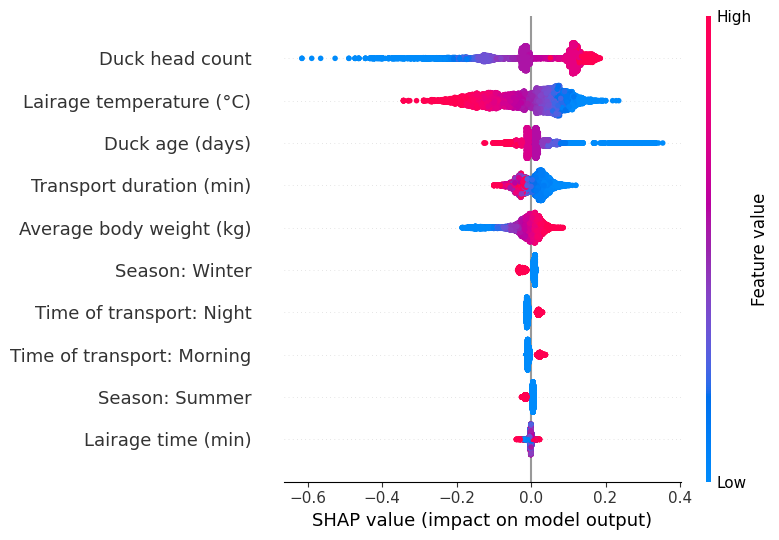

In [76]:
# ✅ Select SHAP values for the 'high' class (class index 1)
shap_values_high = shap_values[..., 1]  # Extracting class 1 (High DOA)

# ✅ Generate the SHAP beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_high,
    X_train_renamed,
    feature_names=ordered_feature_names,  # Ensure correct order
    max_display=10,
    show=False
)

# ✅ Save the plot with high resolution
plt.savefig("shap_summary_plot_beeswarm2.jpg", dpi=600, bbox_inches="tight")
plt.show()

## **Dependence Plot**

In [79]:
print("Available Feature Names in X_train_renamed:", list(X_train_renamed.columns))
print("Ordered Feature Names:", ordered_feature_names)

Available Feature Names in X_train_renamed: ['Duck head count', 'Duck age (days)', 'Average body weight (kg)', 'Lairage temperature (°C)', 'Transport duration (min)', 'Lairage time (min)', 'Season: Summer', 'Season: Winter', 'Time of transport: Morning', 'Time of transport: Night']
Ordered Feature Names: ['Duck head count', 'Duck age (days)', 'Average body weight (kg)', 'Lairage temperature (°C)', 'Transport duration (min)', 'Lairage time (min)', 'Season: Summer', 'Season: Winter', 'Time of transport: Morning', 'Time of transport: Night']


In [81]:
print("SHAP Values High Shape:", shap_values_high.shape)
print("X_train_renamed Shape:", X_train_renamed.shape)
print("X_train_renamed Columns:", list(X_train_renamed.columns))

SHAP Values High Shape: (10306, 10)
X_train_renamed Shape: (10306, 10)
X_train_renamed Columns: ['Duck head count', 'Duck age (days)', 'Average body weight (kg)', 'Lairage temperature (°C)', 'Transport duration (min)', 'Lairage time (min)', 'Season: Summer', 'Season: Winter', 'Time of transport: Morning', 'Time of transport: Night']


In [83]:
print("SHAP Values Structure:", type(shap_values))
print("SHAP Values Shape:", shap_values.shape)

SHAP Values Structure: <class 'shap._explanation.Explanation'>
SHAP Values Shape: (10306, 10, 2)


**Lairage temp VS Head**

<Figure size 640x480 with 0 Axes>

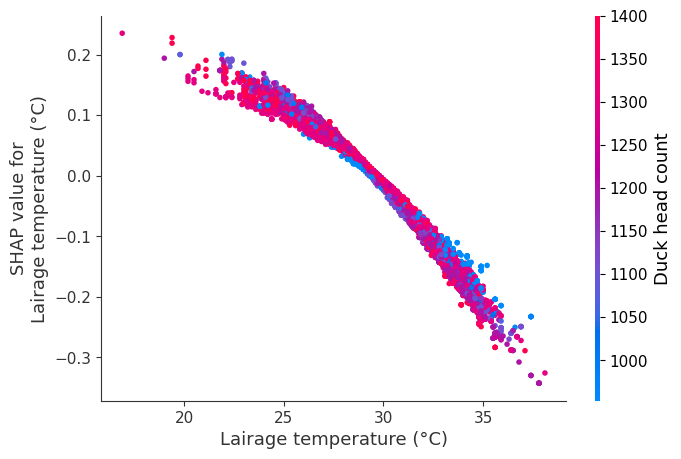

In [85]:
# lairagetemp
import shap
import matplotlib.pyplot as plt

shap_values_high = shap_values.values[:, :, 1]  # Extract SHAP values for High DOA (class index 1)

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=0, #head
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_head.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

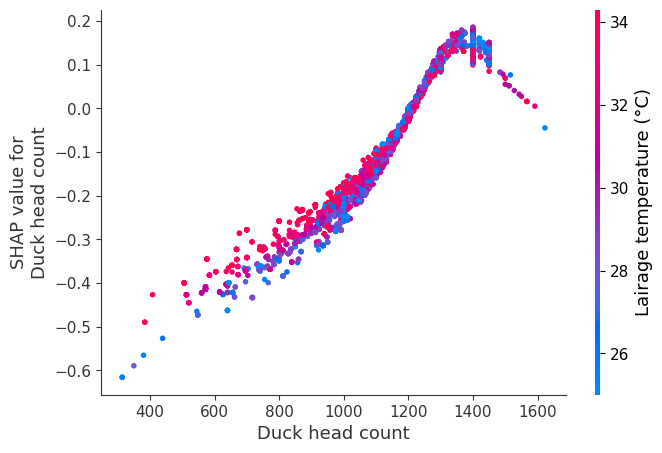

In [86]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=0,  # Feature index for 'head'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=3, #lairagetemp
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_head_lairagetemp.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**head VS age**

<Figure size 640x480 with 0 Axes>

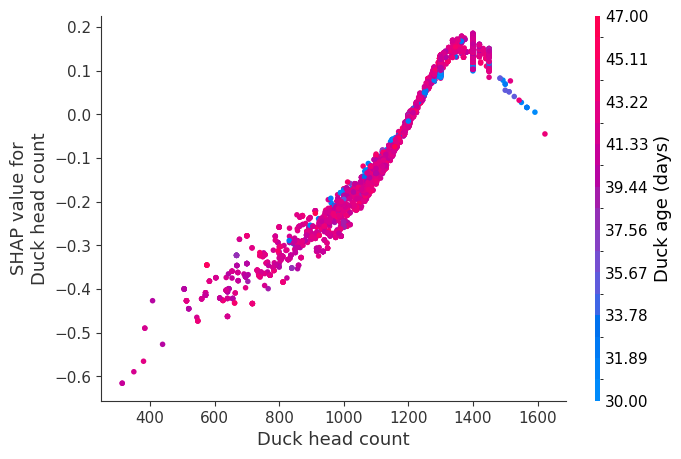

In [87]:
# head
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=0,  # Feature index for 'head'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=1, # age
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_head_age.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

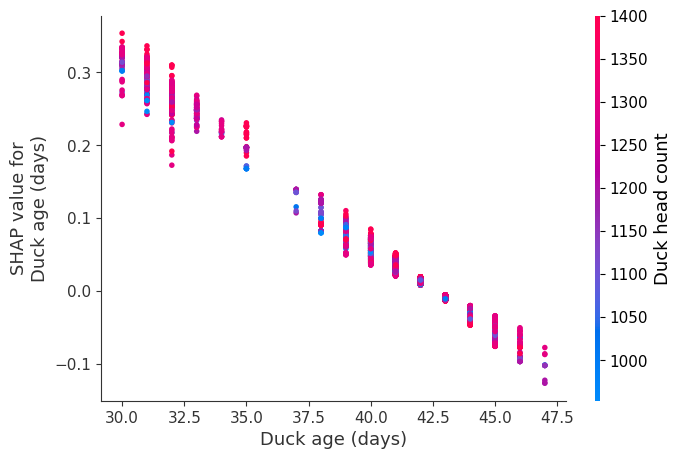

In [89]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=1,  # Feature index for 'age'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=0, #head
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_age_head.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**timetrans VS head**

<Figure size 640x480 with 0 Axes>

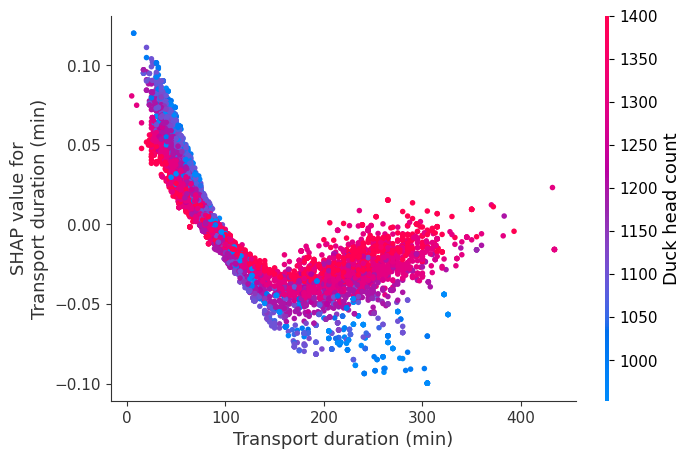

In [90]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=4,  # Feature index for 'durationtransport'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=0, #head
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_durationtrans_head.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

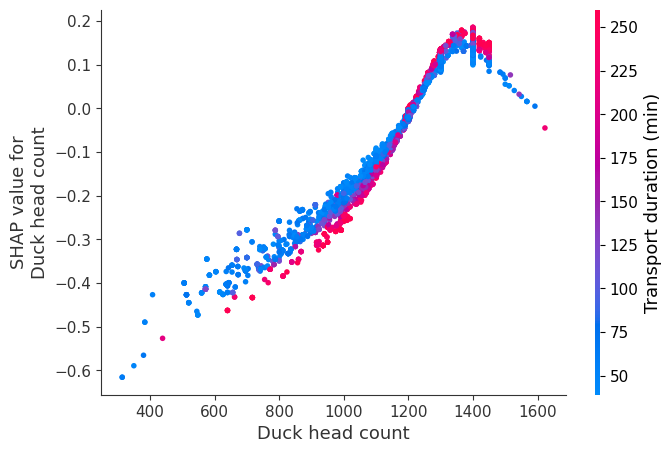

In [91]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=0,  # Feature index for 'head'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=4, #durationtransport
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_head_durationtrans.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**SS.Summer VS duration**

<Figure size 640x480 with 0 Axes>

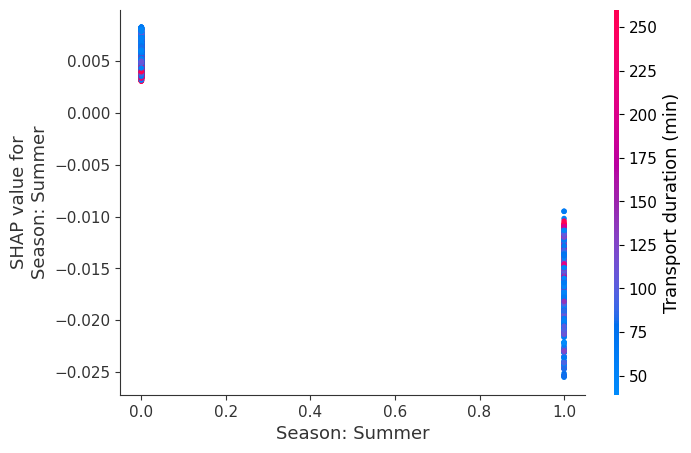

In [92]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=6,  # Feature index for 'ss summer'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=4, #durationtransport
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_summer_durationtrans.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

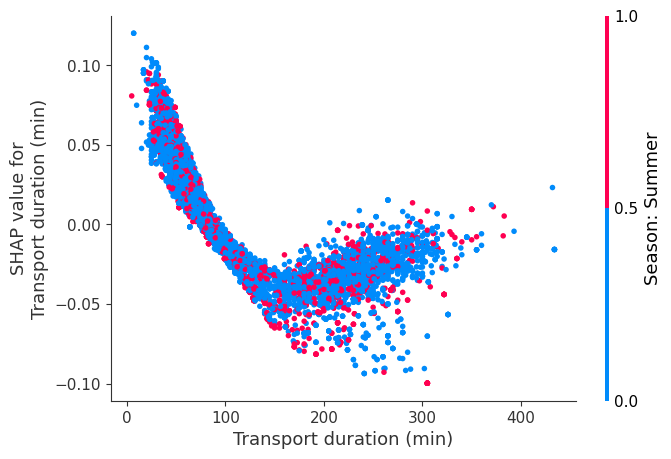

In [93]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=4,  # Feature index for 'durationtransport'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=6, #ss summer
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_durationtrans_summer.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**SS.Winter vs duration**

<Figure size 640x480 with 0 Axes>

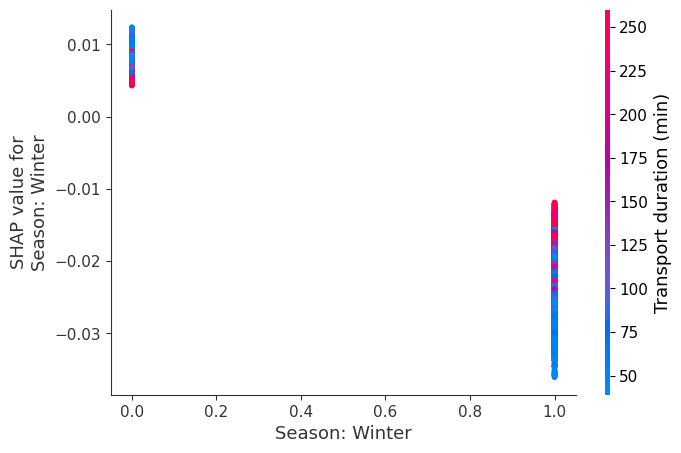

In [94]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=7,  # Feature index for 'ss winter'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=4, #durationtransport
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_winter_durationtrans.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

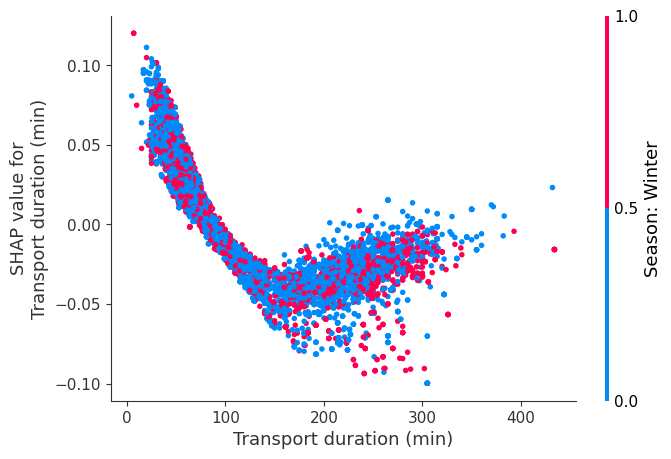

In [95]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=4,  # Feature index for 'durationtransport'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=7, #ss winter
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_durationtrans_winter.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**SS.summer VS lairagetemp**

<Figure size 640x480 with 0 Axes>

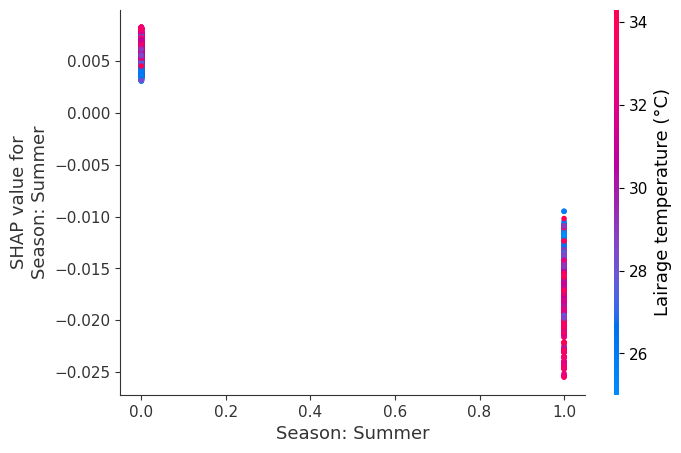

In [96]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=6,  # Feature index for 'ss summer'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=3, #lairagetemp
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_summer_temp.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

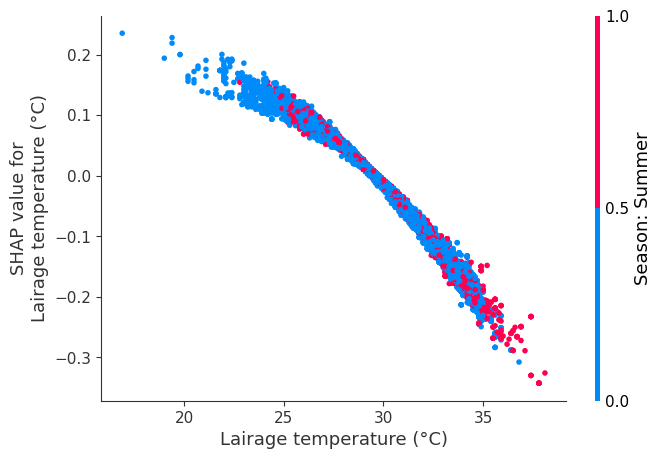

In [97]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=6, #ss summer
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_temp_summer.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**SS.winter vs temp**

<Figure size 640x480 with 0 Axes>

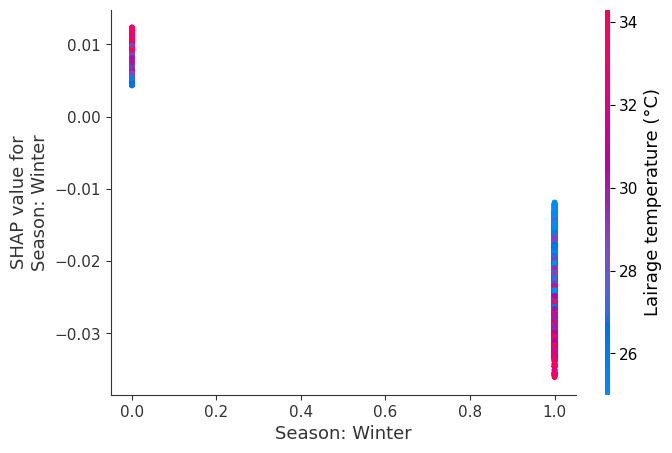

In [98]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=7,  # Feature index for 'ss winter'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=3, #lairagetemp
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_winter_temp.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

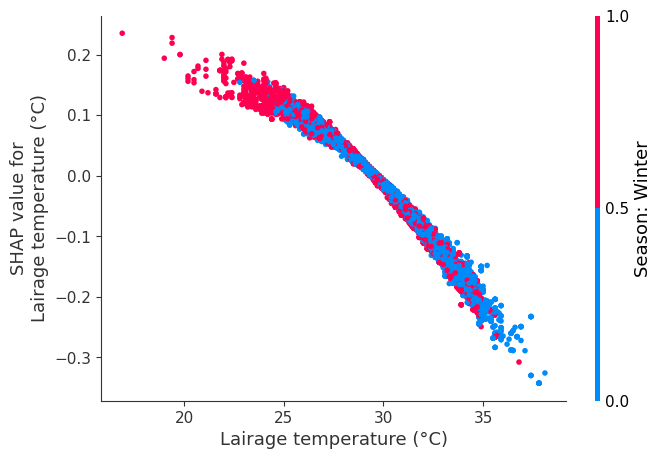

In [99]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=7, #ss winter
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_temp_winter.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

## **Waterfall plot**

**Highest %DOA**

In [100]:
# ✅ Print top pctdoa values and their index
print("🔍 Top 10 pctdoa values:")
print(df[['pctdoa']].sort_values(by='pctdoa', ascending=False).head(10))

🔍 Top 10 pctdoa values:
        pctdoa
787   6.499261
3397  5.857143
2405  5.138340
7896  4.123711
2350  4.083333
5108  4.008016
7980  4.000000
989   3.980583
6921  3.559028
976   3.525641


In [101]:
row_index = df['pctdoa'].idxmax()
print(f"🔍 Index of max pctdoa: {row_index}")

🔍 Index of max pctdoa: 787


In [102]:
print("🔍 Selected row with max pctdoa:\n", df.loc[[row_index]])

🔍 Selected row with max pctdoa:
           date  order             farm  distance  head  age    bw  \
787 2022-03-14     15  Suvannaphumfarm      95.0   677   42  2.23   

            timeoutfarm          timearrive       slaughtertime  lairagetemp  \
787 1900-01-01 12:35:00 1900-01-01 14:13:00 1900-01-01 16:46:00         34.2   

     doa    pctdoa orderc  season timetransport  durationtransport  \
787   44  6.499261   Late  Summer           Day                 98   

     lairagetime classdoa  
787          153     high  


In [103]:
print(f"🔍 Checking if row index {row_index} exists in X_train_numeric...")
print(f"X_train_numeric shape: {X_train_numeric.shape}")

🔍 Checking if row index 787 exists in X_train_numeric...
X_train_numeric shape: (10306, 10)


In [104]:
print(f"Does row index {row_index} exist in X_train_numeric?")
print(row_index in range(X_train_numeric.shape[0]))  # Should return True

Does row index 787 exist in X_train_numeric?
True


In [105]:
print(f"First 5 indices in df: {df.index[:5].tolist()}")
print(f"First 5 indices in X_train_numeric: {list(range(5))}")

First 5 indices in df: [0, 1, 2, 3, 4]
First 5 indices in X_train_numeric: [0, 1, 2, 3, 4]


In [106]:
# Find the actual position of row index 787 in X_train
row_position = X_train.index.get_loc(787)
print(f"🔍 Correct row position of index 787 in X_train_numeric: {row_position}")

🔍 Correct row position of index 787 in X_train_numeric: 1606


In [107]:
# ✅ Select the correctly mapped row from X_train_numeric
X_sample = X_train_numeric[1606:1607]  # Use 1606 as row position

# ✅ Debug: Print the selected row to confirm correctness
print("🔍 Correct row from X_train_numeric:\n", pd.DataFrame(X_sample, columns=X_train.columns))

🔍 Correct row from X_train_numeric:
        head   age    bw  lairagetemp  durationtransport  lairagetime  \
1606  677.0  42.0  2.23    34.200001               98.0        153.0   

      season_Summer  season_Winter  timetransport_Morning  timetransport_Night  
1606            1.0            0.0                    0.0                  0.0  


In [108]:
shap_values_sample = explainer(X_sample)
print("✅ SHAP values computed successfully!")

✅ SHAP values computed successfully!


In [109]:
import matplotlib.pyplot as plt

# ✅ Extract SHAP values for class 1 (High DOA)
shap_values_high_class = shap.Explanation(
    values=shap_values_sample.values[0][:, 1],  # Class 1 (index 1)
    base_values=shap_values_sample.base_values[0][1],  # Base value for Class 1
    data=shap_values_sample.data[0],  # Feature values
    feature_names=ordered_feature_names  # Correct feature names
)

# ✅ Debug: Print SHAP explanation data before plotting
print("\n🔍 SHAP Explanation Data for truck with highest %DOA")
print(shap_values_high_class)


🔍 SHAP Explanation Data for truck with highest %DOA
.values =
array([-0.28611375,  0.00945172, -0.09894795, -0.13449217, -0.0081299 ,
       -0.0051758 , -0.01100466,  0.00657241, -0.00638974, -0.00742214])

.base_values =
0.6005219438672066

.data =
array([677.  ,  42.  ,   2.23,  34.2 ,  98.  , 153.  ,   1.  ,   0.  ,
         0.  ,   0.  ], dtype=float32)


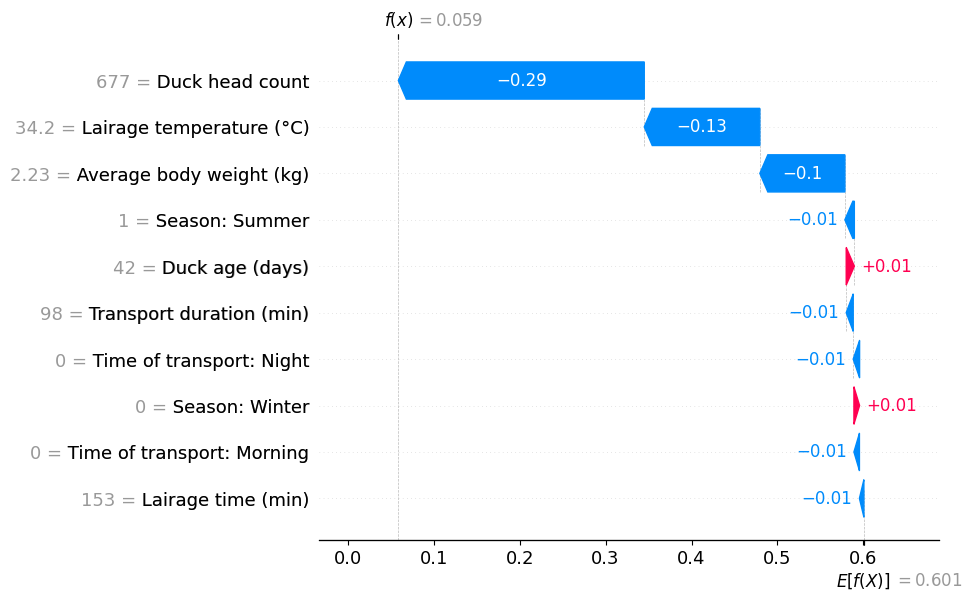

<Figure size 640x480 with 0 Axes>

In [110]:
# ✅ Plot Waterfall Chart for Class 1 (High DOA)
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_high_class)

# ✅ Save the plot
plt.savefig("shap_waterfall_row_highest.jpg", dpi=600, bbox_inches="tight")
plt.show()

**We can conclude that the model incorrectly classified this case into low DOA ☹**

## **Local explanation example: row #976**

In [161]:
# ✅ Find the actual position of row index 976 in X_train
row_position_976 = X_train.index.get_loc(976)
print(f"🔍 Correct row position of index 976 in X_train_numeric: {row_position_976}")

🔍 Correct row position of index 976 in X_train_numeric: 613


In [162]:
# ✅ Select the correctly mapped row from X_train_numeric
X_sample_976 = X_train_numeric[613:614]

# ✅ Debug: Print the selected row to confirm correctness
print("🔍 Correct row from X_train_numeric:\n", pd.DataFrame(X_sample_976, columns=X_train.columns))

🔍 Correct row from X_train_numeric:
        head   age   bw  lairagetemp  durationtransport  lairagetime  \
613  1248.0  40.0  2.6    31.700001               68.0         59.0   

     season_Summer  season_Winter  timetransport_Morning  timetransport_Night  
613            1.0            0.0                    0.0                  0.0  


In [163]:
# ✅ Compute SHAP values for row 976
shap_values_sample_976 = explainer(X_sample_976)
print("✅ SHAP values computed successfully!")

✅ SHAP values computed successfully!


In [164]:
# ✅ Get the model's prediction for row 976
predicted_proba_976 = final_optimized_model.predict(X_sample_976)
predicted_class_976 = np.argmax(predicted_proba_976)  # Get the predicted class
print(f"🔍 Model Predicted Class for Row 976: {predicted_class_976}")

# ✅ Extract SHAP values for the predicted class
shap_values_correct_976 = shap.Explanation(
    values=shap_values_sample_976.values[0][:, predicted_class_976],  # Select predicted class
    base_values=shap_values_sample_976.base_values[0][predicted_class_976],  # Base value
    data=shap_values_sample_976.data[0],  # Feature values
    feature_names=ordered_feature_names  # Correct feature names
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
🔍 Model Predicted Class for Row 976: 1


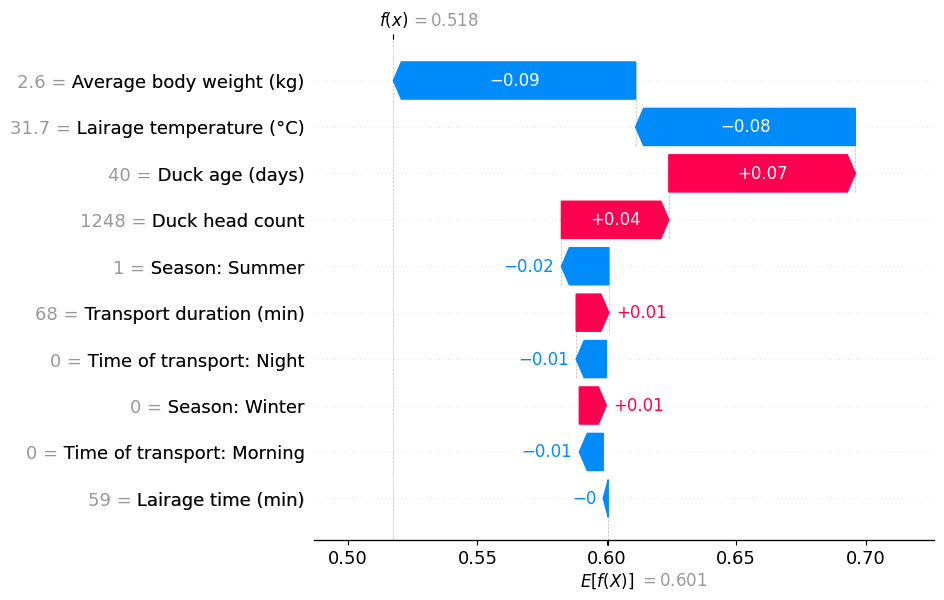

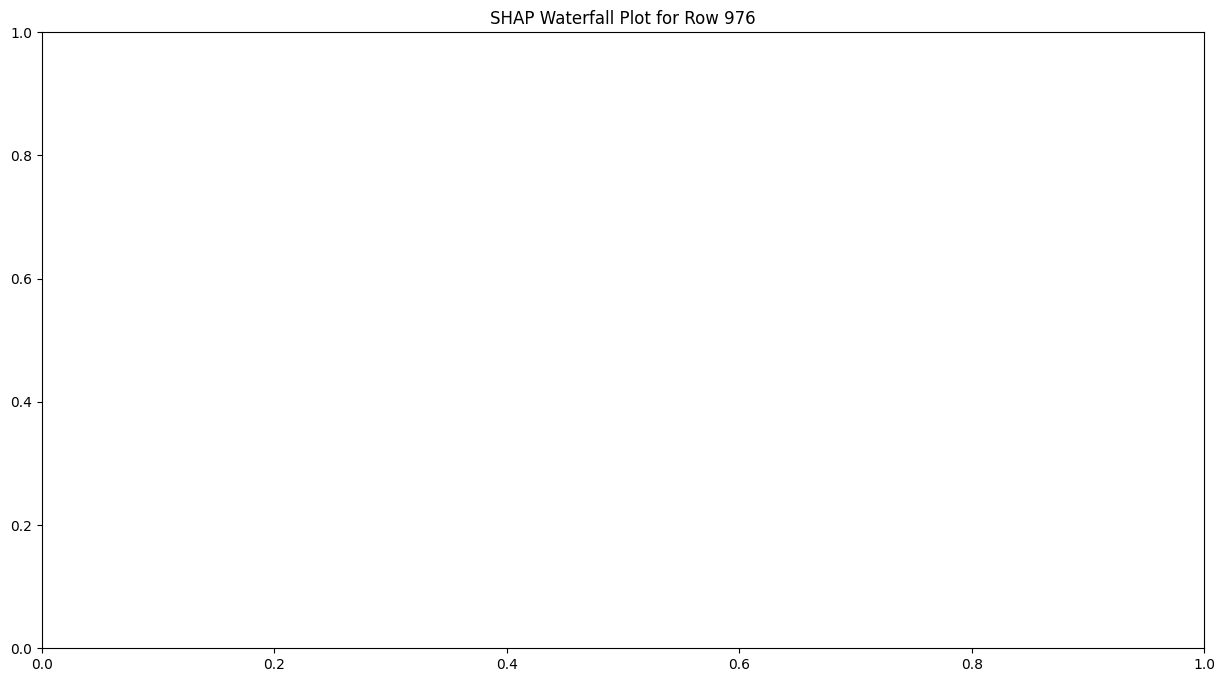

In [165]:
import matplotlib.pyplot as plt

# ✅ Plot the SHAP Waterfall Chart for the predicted class
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_correct_976)
plt.title(f"SHAP Waterfall Plot for Row 976")

# ✅ Save the plot
plt.savefig("shap_waterfall_row_976.jpg", dpi=600, bbox_inches="tight")
plt.show()

## **Local explanation example: row #123**

In [166]:
# ✅ Find the actual position of row index 123 in X_train
row_position_123 = X_train.index.get_loc(123)
print(f"🔍 Correct row position of index 123 in X_train_numeric: {row_position_123}")

🔍 Correct row position of index 123 in X_train_numeric: 6201


In [167]:
# ✅ Select the correctly mapped row from X_train_numeric
X_sample_123 = X_train_numeric[6201:6202]

# ✅ Debug: Print the selected row to confirm correctness
print("🔍 Correct row from X_train_numeric:\n", pd.DataFrame(X_sample_123, columns=X_train.columns))

🔍 Correct row from X_train_numeric:
         head   age    bw  lairagetemp  durationtransport  lairagetime  \
6201  1400.0  44.0  3.24    24.700001              115.0        120.0   

      season_Summer  season_Winter  timetransport_Morning  timetransport_Night  
6201            0.0            1.0                    0.0                  1.0  


In [168]:
# ✅ Compute SHAP values for row 123
shap_values_sample_123 = explainer(X_sample_123)
print("✅ SHAP values computed successfully!")

✅ SHAP values computed successfully!


In [169]:
# ✅ Get the model's prediction for row 123
predicted_proba_123 = final_optimized_model.predict(X_sample_123)
predicted_class_123 = np.argmax(predicted_proba_123)  # Get the predicted class
print(f"🔍 Model Predicted Class for Row 123: {predicted_class_123}")

# ✅ Extract SHAP values for the predicted class
shap_values_correct_123 = shap.Explanation(
    values=shap_values_sample_123.values[0][:, predicted_class_123],  # Select predicted class
    base_values=shap_values_sample_123.base_values[0][predicted_class_123],  # Base value
    data=shap_values_sample_123.data[0],  # Feature values
    feature_names=ordered_feature_names  # Correct feature names
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
🔍 Model Predicted Class for Row 123: 1


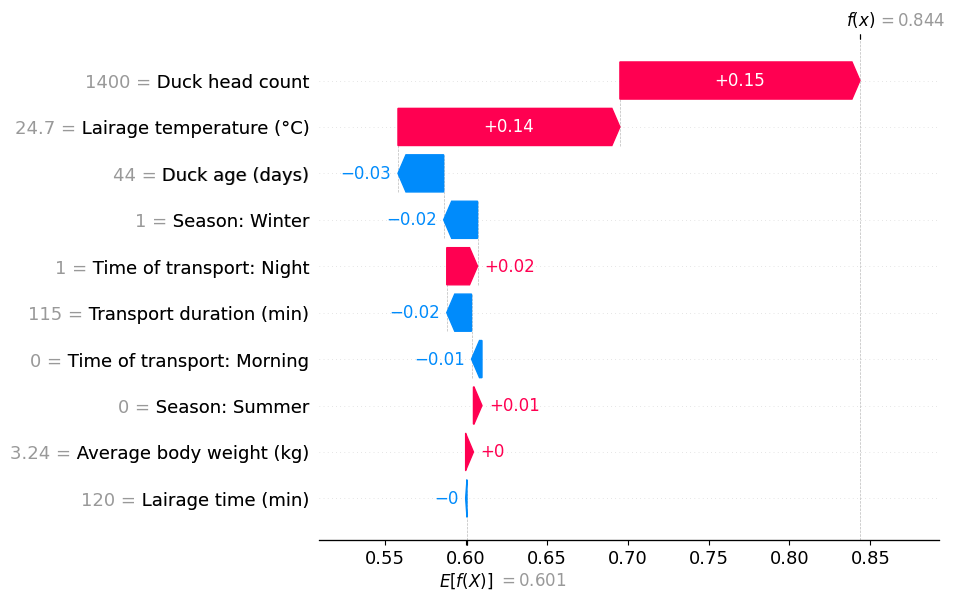

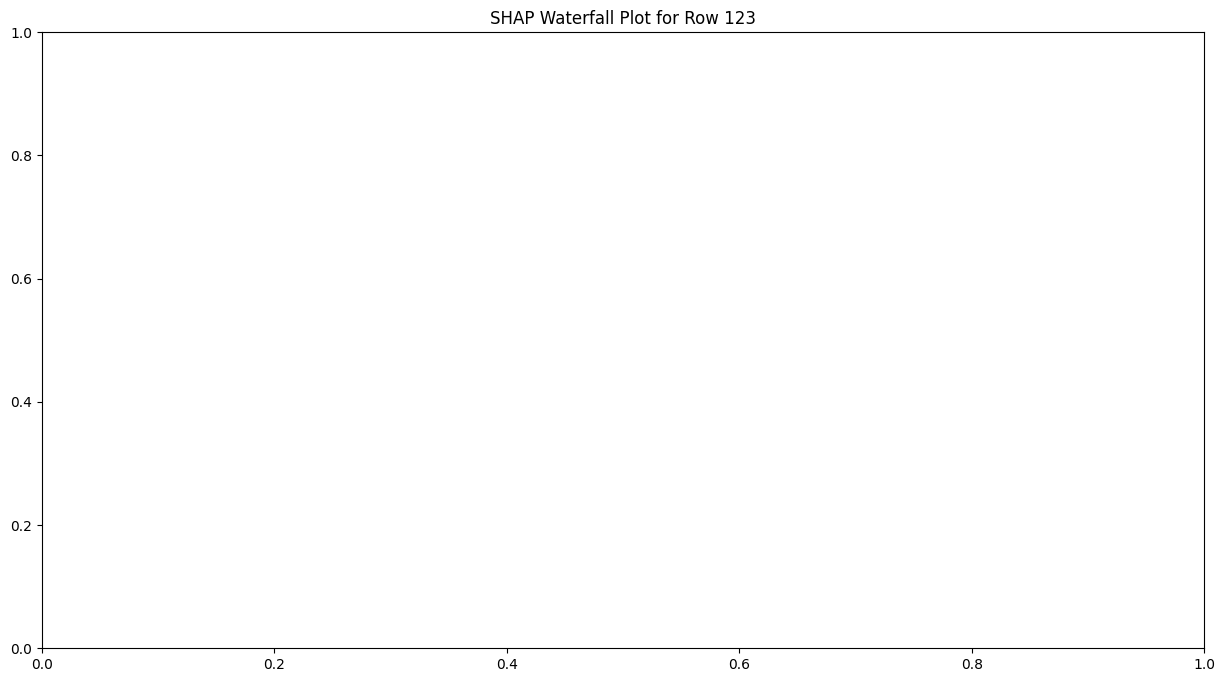

In [170]:
import matplotlib.pyplot as plt

# ✅ Plot the SHAP Waterfall Chart for the predicted class
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_correct_123)
plt.title(f"SHAP Waterfall Plot for Row 123")

# ✅ Save the plot
plt.savefig("shap_waterfall_row_123.jpg", dpi=600, bbox_inches="tight")
plt.show()

## **Force Plot**

In [128]:
# Calculate the expected value (mean prediction for the 'high' class)
expected_value = np.mean(final_optimized_model.predict(X_train_renamed)[:, 1])  # Mean probability for the 'high' class

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [129]:
expected_value_0 = np.mean(final_optimized_model.predict(X_train_renamed)[:, 0])  # Mean probability for the 'low' class

323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [130]:
import shap

shap.initjs()  # Initialize JavaScript visualization

In [133]:
import shap
import matplotlib.pyplot as plt

# Select one instance to explain (e.g., the first row of your dataset)
instance_index = 123  # Replace with the row index you want to visualize
shap_values_single_123 = shap_values.values[instance_index, :, 1]  # SHAP values for 'high' class
features_single_123 = X_train_numeric.iloc[instance_index, :]  # Select full row correctly

# Generate the force plot
shap.initjs()  # Initialize JavaScript for visualization
force_plot_123 = shap.force_plot(
    base_value=expected_value,  # Manually calculated expected value
    shap_values=shap_values_single_123,  # SHAP values for the selected instance
    features=features_single_123,  # Feature values for the selected instance
    feature_names=ordered_feature_names  # Feature names
)

# Display the plot
force_plot_123

In [134]:
import shap

# Save the force plot as an HTML file
shap.save_html("force_plot_instance_123.html", force_plot_123)

# If using Google Colab, download the file to your local machine
from google.colab import files
files.download("force_plot_instance_123.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Force plot for low doa**

In [140]:
import shap

shap.initjs()  # Initialize JavaScript visualization

In [141]:
import shap
import matplotlib.pyplot as plt

# Select one instance to explain (e.g., the first row of your dataset)
instance_index = 124  # Replace with the row index you want to visualize
shap_values_single_124 = shap_values.values[instance_index, :, 0]  # SHAP values for 'low' class
features_single_124 = X_train_numeric.iloc[instance_index, :]  # Select full row correctly

# Generate the force plot
shap.initjs()  # Initialize JavaScript for visualization
force_plot_124 = shap.force_plot(
    base_value=expected_value_0,  # Manually calculated expected value
    shap_values=shap_values_single_124,  # SHAP values for the selected instance
    features=features_single_124,  # Feature values for the selected instance
    feature_names=ordered_feature_names  # Feature names
)

# Display the plot
force_plot_124

In [142]:
import shap

# Save the force plot as an HTML file
shap.save_html("force_plot_instance_124.html", force_plot_124)

# If using Google Colab, download the file to your local machine
from google.colab import files
files.download("force_plot_instance_124.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
# Get the original index of the selected instance
original_index_124 = X_train_numeric.index[instance_index]  # Fetch original dataset index
print("Original Dataset Index for Instance 124:", original_index_124)

Original Dataset Index for Instance 124: 124


## **Decision Plot**

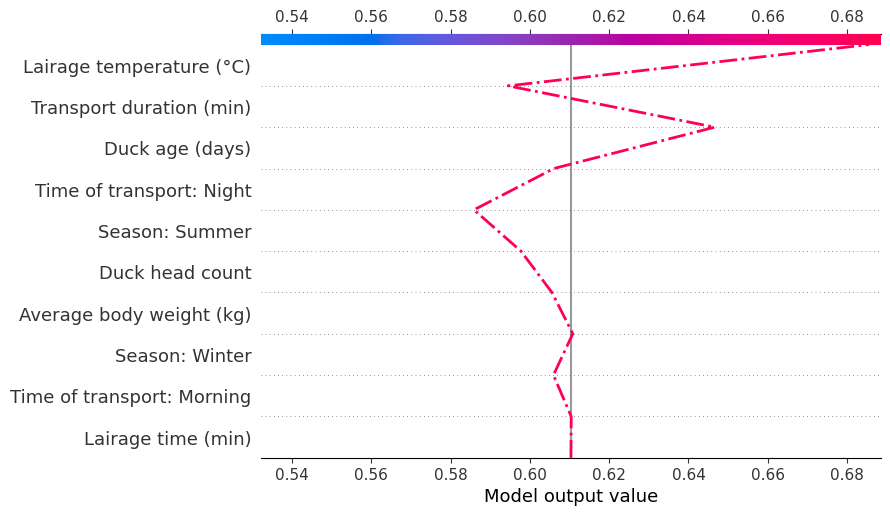

<Figure size 640x480 with 0 Axes>

In [135]:
import shap
import matplotlib.pyplot as plt

# Select an instance to explain (e.g., the first row)
instance_index = 123  # Replace with the desired row index

# Generate a decision plot
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[instance_index, :, 1],  # SHAP values for the 'high' class
    feature_names=ordered_feature_names,             # Feature names
    feature_order="importance",              # Optional: Order features by importance
    highlight=0                              # Optional: Highlight the selected instance
)

# Save the plot with high resolution
plt.savefig("decision_plot_row123.jpg", dpi=600, bbox_inches="tight")

# Display the plot
plt.show()

**All instances**

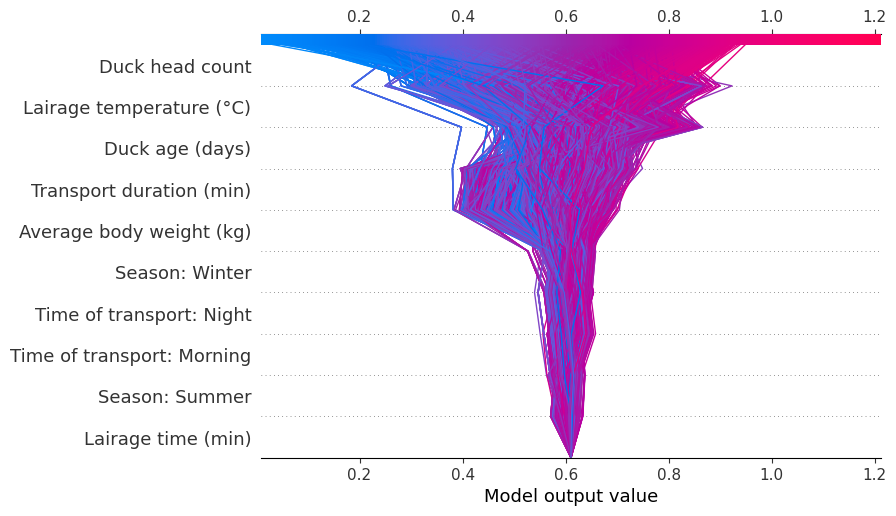

<Figure size 640x480 with 0 Axes>

In [136]:
import shap
import matplotlib.pyplot as plt

# ✅ Increase figure size
plt.figure(figsize=(15, 8))

# Generate a decision plot for all instances
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[:, :, 1],  # SHAP values for the 'high' class (all instances)
    feature_names=ordered_feature_names,             # Feature names
    feature_order="importance",              # Order features by importance
    ignore_warnings=True                     # Ignore warnings about large datasets
)

# Save the plot with high resolution
plt.savefig("decision_plot_all_instance.jpg", dpi=600, bbox_inches="tight")

plt.show()

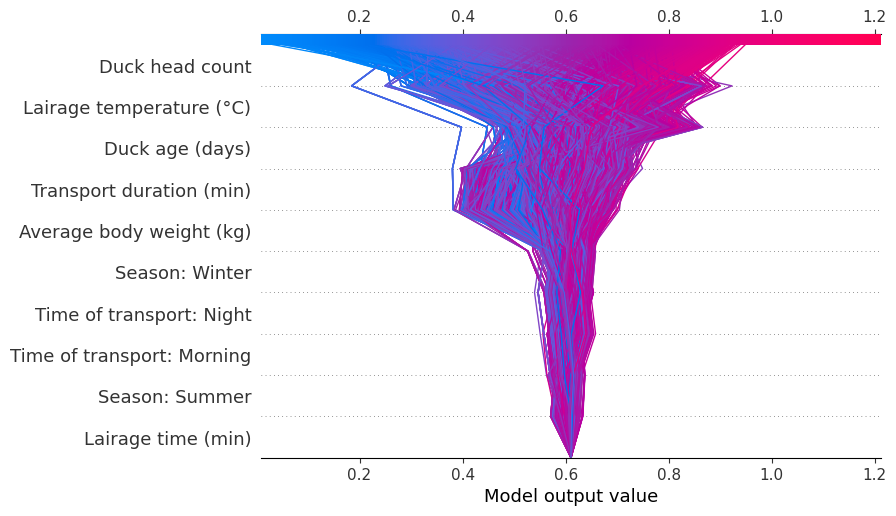

<Figure size 1500x800 with 0 Axes>

In [137]:
import shap
import matplotlib.pyplot as plt

# ✅ Set global figure size
plt.rcParams["figure.figsize"] = (15, 8)  # Set width and height

# ✅ Generate a decision plot for all instances
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[:, :, 1],  # SHAP values for the 'high' class (all instances)
    feature_names=ordered_feature_names,      # Feature names
    feature_order="importance",               # Order features by importance
    ignore_warnings=True                      # Ignore warnings about large datasets
)

# ✅ Save the plot with high resolution
plt.savefig("decision_plot_all_instance2.jpg", dpi=600, bbox_inches="tight")

# ✅ Show in Colab
plt.show()

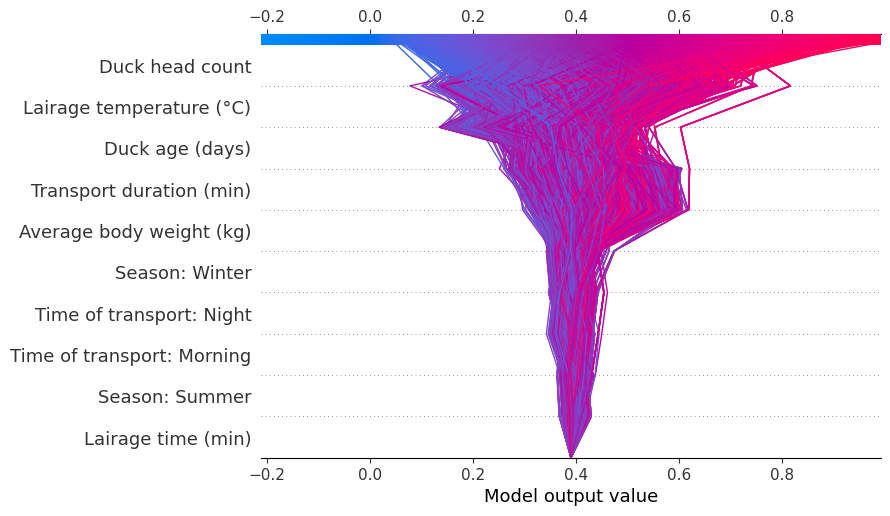

<Figure size 1500x800 with 0 Axes>

In [138]:
# LOW CLASS

import shap
import matplotlib.pyplot as plt

# ✅ Set global figure size
plt.rcParams["figure.figsize"] = (15, 8)  # Set width and height

# ✅ Generate a decision plot for all instances
shap.decision_plot(
    base_value=expected_value_0,                # Manually calculated expected value
    shap_values=shap_values.values[:, :, 0],  # SHAP values for the 'low' class (all instances)
    feature_names=ordered_feature_names,      # Feature names
    feature_order="importance",               # Order features by importance
    ignore_warnings=True                      # Ignore warnings about large datasets
)

# ✅ Save the plot with high resolution
plt.savefig("decision_plot_all_instance_lowdoa.jpg", dpi=600, bbox_inches="tight")

# ✅ Show in Colab
plt.show()

# **Correlation Matrix**

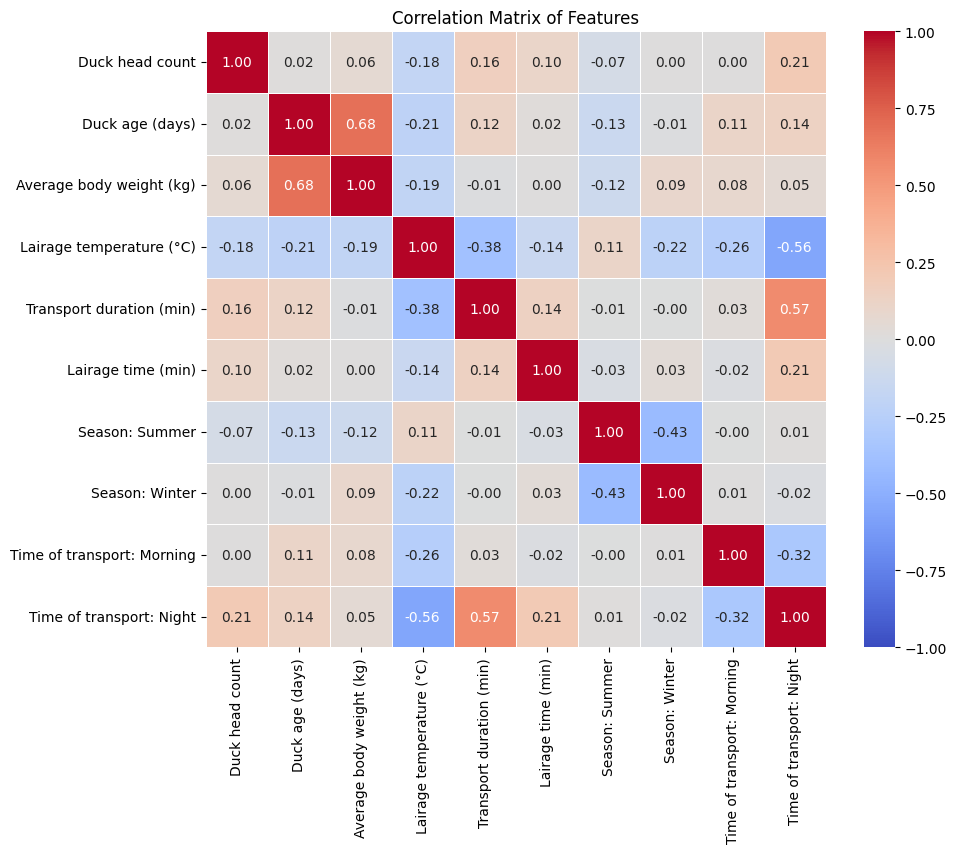

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Compute correlation matrix
corr_matrix = X_train_renamed.corr()

# ✅ Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,  # Show correlation values
    fmt=".2f",  # Format numbers
    cmap="coolwarm",  # Color theme
    linewidths=0.5,
    vmin=-1, vmax=1
)

# ✅ Add title
plt.title("Correlation Matrix of Features")

# ✅ Save and Show
plt.savefig("correlation_matrix.jpg", dpi=600, bbox_inches="tight")
plt.show()

# **Save files & Make the work reproducible**
remove # for running the code

In [186]:
#!pip freeze > requirements.txt

In [187]:
#from google.colab import files
#files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [188]:
#os.listdir()

['.config',
 'decision_plot_all_instance.jpg',
 'dependence_head_durationtrans.jpg',
 'dependence_winter_durationtrans.jpg',
 'dependence_head_age.jpg',
 'force_plot_instance_124.html',
 'dependence_summer_durationtrans.jpg',
 'DOA-data_65-66_for_NN.xlsx',
 'correlation_matrix.jpg',
 'shap_waterfall_row_976.jpg',
 'requirements.txt',
 'shap_summary_plot_beeswarm2.jpg',
 'dependence_temp_summer.jpg',
 'force_plot_instance_123.html',
 'shap_waterfall_row_highest.jpg',
 'dependence_summer_temp.jpg',
 'decision_plot_all_instance2.jpg',
 'dependence_durationtrans_summer.jpg',
 'dependence_head_lairagetemp.jpg',
 'decision_plot_row123.jpg',
 'dependence_lairagetemp_head.jpg',
 'dependence_winter_temp.jpg',
 'decision_plot_all_instance_lowdoa.jpg',
 'dependence_durationtrans_winter.jpg',
 'shap_waterfall_row_123.jpg',
 'dependence_age_head.jpg',
 'dependence_temp_winter.jpg',
 'dependence_durationtrans_head.jpg',
 'sample_data']

In [189]:
#!zip -r project_journal_resampling.zip *

  adding: correlation_matrix.jpg (deflated 46%)
  adding: decision_plot_all_instance2.jpg (deflated 100%)
  adding: decision_plot_all_instance.jpg (deflated 100%)
  adding: decision_plot_all_instance_lowdoa.jpg (deflated 100%)
  adding: decision_plot_row123.jpg (deflated 100%)
  adding: dependence_age_head.jpg (deflated 52%)
  adding: dependence_durationtrans_head.jpg (deflated 38%)
  adding: dependence_durationtrans_summer.jpg (deflated 38%)
  adding: dependence_durationtrans_winter.jpg (deflated 37%)
  adding: dependence_head_age.jpg (deflated 44%)
  adding: dependence_head_durationtrans.jpg (deflated 45%)
  adding: dependence_head_lairagetemp.jpg (deflated 52%)
  adding: dependence_lairagetemp_head.jpg (deflated 47%)
  adding: dependence_summer_durationtrans.jpg (deflated 57%)
  adding: dependence_summer_temp.jpg (deflated 58%)
  adding: dependence_temp_summer.jpg (deflated 51%)
  adding: dependence_temp_winter.jpg (deflated 51%)
  adding: dependence_winter_durationtrans.jpg (deflat

In [190]:
#from google.colab import files
#files.download("project_journal_resampling.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Reproduce the Environment**

In [ ]:
#pip install -r requirements.txt


### ▶ ALL DONE ◀



